In [1]:
import numpy as np 
import pandas as pd 
#import pydicom
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from PIL import Image
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, roc_curve, auc
from efficientnet_pytorch import EfficientNet

In [2]:
# upload train dataframe
train_df_allsamples = pd.read_csv("../TrainTestDataFrames/marking.csv")
train_df_allsamples.head()

,patient_id,image_id,target,source,sex,age_approx,anatom_site_general_challenge
0,IP_7279968,ISIC_2637011,0,ISIC20,male,45.0,head/neck
1,IP_3075186,ISIC_0015719,0,ISIC20,female,45.0,upper extremity
2,IP_2842074,ISIC_0052212,0,ISIC20,female,50.0,lower extremity
3,IP_6890425,ISIC_0068279,0,ISIC20,female,45.0,head/neck
4,IP_8723313,ISIC_0074268,0,ISIC20,female,55.0,upper extremity


In [3]:
# create dictionary that maps image name to target 
image_names = train_df_allsamples["image_id"].values 
targets = train_df_allsamples["target"].values
img_to_target = {image_name:target for image_name, target in zip(image_names, targets)}

percent_tp = sum(targets)/len(targets) * 100 
print("{} training samples total.".format(len(targets)))
print("Only {:.3f} percent of training data set is a true positive.".format(percent_tp))
print("Therefore, the baseline accuracy is {:.3f}".format(np.max([percent_tp, 100-percent_tp])))

60487 training samples total.
Only 9.058 percent of training data set is a true positive.
Therefore, the baseline accuracy is 90.942


In [4]:
# update so that the number of positives balances negatives
train_df_pos = train_df_allsamples.iloc[targets>0, :]
train_df_neg = train_df_allsamples.iloc[targets==0, :]
train_df_negsample = train_df_neg.sample(n=int(train_df_pos.shape[0]))

# concatenate negative and positive samples, then shuffle using .sample() 
#train_val_df = pd.concat((train_df_pos, train_df_negsample)).sample(frac=1)
train_val_df = train_df_allsamples.sample(frac=.5)

train_val_split = .9
n_train_val = train_val_df.shape[0]
n_train = int(train_val_split*n_train_val)

train_df = train_val_df[:n_train]
val_df = train_val_df[n_train:]

# create dictionary that maps image name to target 
image_names = val_df["image_id"].values 
val_targets = val_df["target"].values

percent_tp = sum(val_targets)/len(val_targets) * 100 
baseline = np.max([percent_tp, 100-percent_tp])

print("{} Training and {} Validation samples".format(n_train, n_train_val-n_train))
print("{:.3f} percent of validation data set is a positive.".format(percent_tp))
print("Baseline validation accuracy is {:.3f}".format(baseline))

54438 Training and 6049 Validation samples
8.613 percent of validation data set is a positive.
Baseline validation accuracy is 91.387


In [5]:
# Device configuration (GPU can be enabled in settings)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda:0


In [6]:
meta_features = ['sex', 'age_approx', 'anatom_site_general_challenge'] 

encoder = {}
for feature in meta_features: 
    # determine unique features  
    categories = np.unique(np.array(train_df[feature].values, str))
    for i, category in enumerate(categories): 
        if category != 'nan':
            encoder[category] = np.float(i)
encoder['nan'] = np.nan

# define a unique transform each time a positive is resampled: 

# basic transform 
transform_1 = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.RandomResizedCrop(size=256, scale=(0.5, 1.0), ratio=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

# horizontal or vertical flip 
transform_2 = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.RandomResizedCrop(size=256, scale=(0.5, 1.0), ratio=(0.8, 1.2)),
    #transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

# no flip or rotation for test/validation data 
transform_valid = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(1.0, 1.0), ratio=(1.0, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

def make_weights_for_balanced_classes(df, nclasses=2):   
    targets = df["target"].values
    count = [0] * nclasses                                                      
    for label in targets:                                                         
        count[label] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(targets)                                              
    for idx, label in enumerate(targets):                                          
        weight[idx] = weight_per_class[label]   
        
    return np.array(weight)  

class ValidDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_id'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path)
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform).
        img = Image.fromarray(img)
        #img = img.resize((256, 256))
        img_processed = transform_valid(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

class MyDataLoader():
    def __init__(self, df, path, batchsize, min_balance=None):
        # store df, path, weights, ...
        self.df = df 
        self.path = path
        self.w = make_weights_for_balanced_classes(df)
        self.batchsize = batchsize 
        self.balanced = True
        self.min_balance = min_balance
        
        # create a dictionary to map image_ids to index and target in dataframe 
        image_ids = self.df['image_id'].values 
        self.targets = self.df['target'].values
        inds = np.arange(len(image_ids))
        self.imgID2Idx = {im_id:ind for (im_id, ind) in zip(image_ids, inds)}
        self.imgID2Target = {im_id:target for (im_id, target) in zip(image_ids, self.targets)}
        
        # keep track of how many times samples have been drawn 
        self.counts = np.zeros(len(image_ids))
        
    def get_batch(self):
        # get image ids for the batch 
        if np.sum(self.w > 0) >= self.batchsize:
            batch_image_ids = self.df.sample(n=self.batchsize, weights=self.w)['image_id'].values
        else:
            # update batchsize 
            print("Updating batchsize, maximum dataset size reached")
            self.batchsize = np.sum(self.w > 0)
            batch_image_ids = self.df.sample(n=self.batchsize, weights=self.w)['image_id'].values
        
        # get the index locations for the image ids 
        batch_sample_inds = [self.imgID2Idx[im_id] for im_id in batch_image_ids]
        batch_targets = [self.imgID2Target[im_id] for im_id in batch_image_ids]
        
        # Update counts 
        self.counts[batch_sample_inds] += 1
        
        # Update sampling weights so that target=0 --> w = 0, target=1 --> w /= 2 
        for ind, target in zip(batch_sample_inds, batch_targets):
            # if the sample is a negative, then we don't want to sample it again 
            # if the sample has already been sampled 2 times, it shouldn't be sampled again
            # if target is positive, sampling should happen less frequently 
            if target == 0 or self.counts[ind] == 2:
                self.w[ind] = 0 
            else:
                self.w[ind] /= 2 
        
        # Data returned in shape [Batchsize, Channels, H, W]
        images = np.zeros((self.batchsize, 3, 256, 256)) 
        labels = np.zeros(self.batchsize)
        #meta_data = np.zeros((self.batchsize, 3))
        
        for i, index in enumerate(batch_sample_inds):
            
            # 1. load image
            img_name = self.df['image_id'].values[index]
            img_path = self.path + img_name + ".jpg"
            img = plt.imread(img_path)

            # 2. Preprocess the data (e.g. torchvision.Transform).
            img = Image.fromarray(img)
            if self.counts[index] == 1:
                images[i, :, :, :] = transform_1(img)
            if self.counts[index] == 2:
                images[i, :, :, :] = transform_2(img)

            # 3. store label 
            labels[i] = self.imgID2Target[img_name]
                
        # Quit once all positive samples have zero valued weights 
        if np.sum(self.w[self.targets==1]) == 0:
            self.balanced = False
            
        # If a min balance is specified, quit at min balance
        if self.min_balance:
            if sum(labels)/len(labels) <= self.min_balance:
                self.balanced = False
        
        # return data 
        X = torch.tensor(images, dtype = torch.float32)
        y = torch.tensor(labels, dtype = torch.float32)
        return X, y #, meta_data

In [7]:
# First, load the EfficientNet with pre-trained parameters 
ENet = EfficientNet.from_pretrained('efficientnet-b0').to(device)

Loaded pretrained weights for efficientnet-b0


In [8]:
# Convolutional neural network
class MyENet(nn.Module):
    def __init__(self, ENet):
        super(MyENet, self).__init__()
        # modify output layer of the pre-trained ENet 
        self.ENet = ENet
        num_ftrs = self.ENet._fc.in_features
        self.ENet._fc = nn.Linear(in_features=num_ftrs, out_features=256, bias=True)
        # map Enet output to melanoma decision 
        self.output = nn.Sequential(nn.BatchNorm1d(256),
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=0.2),
                                    nn.Linear(256, 1), 
                                    nn.Sigmoid())
        
    def embedding(self, x):
        out = self.ENet(x)
        return out 
        
    def forward(self, x):
        out = self.ENet(x)
        out = self.output(out)
        return out

model = MyENet(ENet).to(device)
#model.load_state_dict(torch.load('../Models/ENETmodel_all.ckpt'))

In [9]:
# Train the model
# Use the prebuilt data loader.
path = "../../data-512/512x512-dataset-melanoma/512x512-dataset-melanoma/"
path_to_model = '../Models/ENETmodel.ckpt'

# evaluate performance on validation data 
valid_dataset = ValidDataset(val_df, path)                                              
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset) 


# save losses from training 
num_epochs = 50
batchsize  = 25

train_roc = []
val_roc   = []
losses    = []
patience     = 3
set_patience = 3 
best_val     = 0

# Loss and optimizer
criterion = nn.BCELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# scheduler reduces learning rate by factor of 10 when val auc does not improve
scheduler = ReduceLROnPlateau(optimizer=optimizer, min_lr=3e-6, mode='max', patience=0, verbose=True)


for epoch in range(num_epochs):
    train_loader = MyDataLoader(train_df, path, batchsize=batchsize, min_balance=.25)
    while train_loader.balanced:
        images, labels = train_loader.get_batch()

        # set up model for training 
        model = model.train()
        
        images = images.to(device)
        labels = torch.reshape(labels, [len(labels), 1])
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # store loss
        losses.append(loss)
        
        # Calculate ROC
        predictions = outputs.detach().cpu().numpy().ravel()
        targets = labels.cpu().numpy().ravel()

        fpr, tpr, _ = roc_curve(np.array(targets, np.int), np.array(predictions).ravel())
        train_roc_auc = auc(fpr, tpr)
        train_roc.append(train_roc_auc)
        
        # Calculate balance 
        balance = np.sum(targets) / len(targets)
        
        print ('Epoch [{}/{}], Balance {:.2f}, Loss: {:.4f}, Train ROC AUC: {:.4f}' 
               .format(epoch+1, num_epochs, balance, loss.item(), train_roc_auc))
        
    # prep model for evaluation
    valid_predictions = []
    valid_targets = []
    model.eval() 
    with torch.no_grad():
        for j, (images, labels) in enumerate(valid_loader):
            images = images.to(device)

            labels = torch.reshape(labels, [len(labels), 1])
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate val ROC
            valid_predictions += list(outputs.detach().cpu().numpy().ravel())
            valid_targets += list(labels.cpu().numpy().ravel()) 

    fpr, tpr, _ = roc_curve(np.array(valid_targets, np.int), np.array(valid_predictions).ravel())
    val_roc_auc = auc(fpr, tpr)
    val_roc.append(val_roc_auc)
    
    print ('\nEpoch [{}/{}], Val ROC AUC: {:.4f}\n'.format(epoch+1, num_epochs, val_roc_auc))
    
    # learning rate is reduced if val roc doesn't improve 
    scheduler.step(val_roc_auc)
    
    if val_roc_auc >= best_val:
        best_val = val_roc_auc
        patience = set_patience        
        torch.save(model.state_dict(), path_to_model)  
    else:
        patience -= 1
        if patience == 0:
            print('Early stopping. Best validation roc_auc: {:.3f}'.format(best_val))
            model.load_state_dict(torch.load(path_to_model), strict=False)
            break

# Load best model 
model.load_state_dict(torch.load(path_to_model))

Epoch [1/50], Balance 0.52, Loss: 0.7220, Train ROC AUC: 0.5064
Epoch [1/50], Balance 0.44, Loss: 0.6622, Train ROC AUC: 0.6299
Epoch [1/50], Balance 0.64, Loss: 0.5262, Train ROC AUC: 0.8889
Epoch [1/50], Balance 0.56, Loss: 0.5924, Train ROC AUC: 0.7597
Epoch [1/50], Balance 0.44, Loss: 0.5089, Train ROC AUC: 0.8117
Epoch [1/50], Balance 0.56, Loss: 0.4337, Train ROC AUC: 0.9026
Epoch [1/50], Balance 0.44, Loss: 0.4404, Train ROC AUC: 0.8571
Epoch [1/50], Balance 0.48, Loss: 0.9762, Train ROC AUC: 0.6026
Epoch [1/50], Balance 0.52, Loss: 0.4085, Train ROC AUC: 0.9167
Epoch [1/50], Balance 0.40, Loss: 0.6750, Train ROC AUC: 0.7867
Epoch [1/50], Balance 0.56, Loss: 0.6298, Train ROC AUC: 0.7792
Epoch [1/50], Balance 0.60, Loss: 0.6113, Train ROC AUC: 0.7400
Epoch [1/50], Balance 0.52, Loss: 0.4318, Train ROC AUC: 0.8654
Epoch [1/50], Balance 0.44, Loss: 0.4678, Train ROC AUC: 0.8442
Epoch [1/50], Balance 0.56, Loss: 0.5445, Train ROC AUC: 0.8247
Epoch [1/50], Balance 0.56, Loss: 0.5809

Epoch [2/50], Balance 0.52, Loss: 0.4296, Train ROC AUC: 0.8910
Epoch [2/50], Balance 0.52, Loss: 0.4388, Train ROC AUC: 0.9103
Epoch [2/50], Balance 0.52, Loss: 0.4138, Train ROC AUC: 0.9231
Epoch [2/50], Balance 0.44, Loss: 0.3410, Train ROC AUC: 0.9351
Epoch [2/50], Balance 0.52, Loss: 0.4304, Train ROC AUC: 0.8718
Epoch [2/50], Balance 0.56, Loss: 0.5088, Train ROC AUC: 0.8571
Epoch [2/50], Balance 0.52, Loss: 0.4838, Train ROC AUC: 0.8269
Epoch [2/50], Balance 0.36, Loss: 0.4424, Train ROC AUC: 0.9097
Epoch [2/50], Balance 0.36, Loss: 0.3579, Train ROC AUC: 0.9514
Epoch [2/50], Balance 0.40, Loss: 0.5353, Train ROC AUC: 0.8333
Epoch [2/50], Balance 0.44, Loss: 0.3656, Train ROC AUC: 0.9156
Epoch [2/50], Balance 0.48, Loss: 0.4678, Train ROC AUC: 0.8462
Epoch [2/50], Balance 0.52, Loss: 0.4318, Train ROC AUC: 0.9231
Epoch [2/50], Balance 0.56, Loss: 0.4622, Train ROC AUC: 0.8766
Epoch [2/50], Balance 0.48, Loss: 0.3441, Train ROC AUC: 0.8974
Epoch [2/50], Balance 0.64, Loss: 0.5425

Epoch [4/50], Balance 0.44, Loss: 0.3412, Train ROC AUC: 0.9740
Epoch [4/50], Balance 0.48, Loss: 0.4379, Train ROC AUC: 0.8654
Epoch [4/50], Balance 0.52, Loss: 0.3603, Train ROC AUC: 0.9167
Epoch [4/50], Balance 0.52, Loss: 0.3197, Train ROC AUC: 0.9551
Epoch [4/50], Balance 0.56, Loss: 0.2715, Train ROC AUC: 0.9805
Epoch [4/50], Balance 0.24, Loss: 0.5248, Train ROC AUC: 0.9561

Epoch [4/50], Val ROC AUC: 0.8980

Epoch [5/50], Balance 0.56, Loss: 0.3427, Train ROC AUC: 0.9545
Epoch [5/50], Balance 0.64, Loss: 0.3756, Train ROC AUC: 0.9097
Epoch [5/50], Balance 0.72, Loss: 0.5912, Train ROC AUC: 0.7143
Epoch [5/50], Balance 0.60, Loss: 0.5555, Train ROC AUC: 0.8067
Epoch [5/50], Balance 0.68, Loss: 0.3636, Train ROC AUC: 0.9412
Epoch [5/50], Balance 0.40, Loss: 0.3014, Train ROC AUC: 0.9800
Epoch [5/50], Balance 0.60, Loss: 0.4651, Train ROC AUC: 0.8533
Epoch [5/50], Balance 0.72, Loss: 0.6137, Train ROC AUC: 0.8016
Epoch [5/50], Balance 0.44, Loss: 0.4262, Train ROC AUC: 0.9156
Epoc

Epoch [6/50], Balance 0.56, Loss: 0.3386, Train ROC AUC: 0.9221
Epoch [6/50], Balance 0.52, Loss: 0.4833, Train ROC AUC: 0.8590
Epoch [6/50], Balance 0.48, Loss: 0.4007, Train ROC AUC: 0.8782
Epoch [6/50], Balance 0.44, Loss: 0.3389, Train ROC AUC: 0.9156
Epoch [6/50], Balance 0.44, Loss: 0.4143, Train ROC AUC: 0.9286
Epoch [6/50], Balance 0.52, Loss: 0.4263, Train ROC AUC: 0.8974
Epoch [6/50], Balance 0.44, Loss: 0.3383, Train ROC AUC: 0.9351
Epoch [6/50], Balance 0.36, Loss: 0.5471, Train ROC AUC: 0.8403
Epoch [6/50], Balance 0.56, Loss: 0.5157, Train ROC AUC: 0.7792
Epoch [6/50], Balance 0.56, Loss: 0.5279, Train ROC AUC: 0.7857
Epoch [6/50], Balance 0.40, Loss: 0.5075, Train ROC AUC: 0.8533
Epoch [6/50], Balance 0.40, Loss: 0.4808, Train ROC AUC: 0.8333
Epoch [6/50], Balance 0.44, Loss: 0.4977, Train ROC AUC: 0.8571
Epoch [6/50], Balance 0.44, Loss: 0.2840, Train ROC AUC: 0.9740
Epoch [6/50], Balance 0.20, Loss: 0.5693, Train ROC AUC: 0.8900

Epoch [6/50], Val ROC AUC: 0.9151

Epoc

Epoch [7/50], Balance 0.64, Loss: 0.3734, Train ROC AUC: 0.9514
Epoch [7/50], Balance 0.56, Loss: 0.3389, Train ROC AUC: 0.9481
Epoch [7/50], Balance 0.52, Loss: 0.3320, Train ROC AUC: 0.9231
Epoch [7/50], Balance 0.56, Loss: 0.3831, Train ROC AUC: 0.9156
Epoch [7/50], Balance 0.44, Loss: 0.4752, Train ROC AUC: 0.8506
Epoch [7/50], Balance 0.28, Loss: 0.7121, Train ROC AUC: 0.7698
Epoch [7/50], Balance 0.64, Loss: 0.4222, Train ROC AUC: 0.9167
Epoch [7/50], Balance 0.40, Loss: 0.3283, Train ROC AUC: 0.9533
Epoch [7/50], Balance 0.48, Loss: 0.4073, Train ROC AUC: 0.8846
Epoch [7/50], Balance 0.44, Loss: 0.6569, Train ROC AUC: 0.7727
Epoch [7/50], Balance 0.44, Loss: 0.4080, Train ROC AUC: 0.8896
Epoch [7/50], Balance 0.24, Loss: 0.4762, Train ROC AUC: 0.9298

Epoch [7/50], Val ROC AUC: 0.9199

Epoch [8/50], Balance 0.64, Loss: 0.6519, Train ROC AUC: 0.7500
Epoch [8/50], Balance 0.60, Loss: 0.5422, Train ROC AUC: 0.8533
Epoch [8/50], Balance 0.60, Loss: 0.2482, Train ROC AUC: 0.9800
Epoc

Epoch [8/50], Balance 0.52, Loss: 0.3309, Train ROC AUC: 0.9231
Epoch [8/50], Balance 0.64, Loss: 0.4402, Train ROC AUC: 0.9236
Epoch [8/50], Balance 0.48, Loss: 0.3410, Train ROC AUC: 0.9295
Epoch [8/50], Balance 0.36, Loss: 0.3298, Train ROC AUC: 0.9444
Epoch [8/50], Balance 0.44, Loss: 0.5487, Train ROC AUC: 0.8377
Epoch [8/50], Balance 0.48, Loss: 0.4661, Train ROC AUC: 0.8333
Epoch [8/50], Balance 0.48, Loss: 0.2923, Train ROC AUC: 0.9487
Epoch [8/50], Balance 0.48, Loss: 0.4990, Train ROC AUC: 0.8590
Epoch [8/50], Balance 0.56, Loss: 0.6847, Train ROC AUC: 0.7987
Epoch [8/50], Balance 0.52, Loss: 0.3445, Train ROC AUC: 0.9487
Epoch [8/50], Balance 0.40, Loss: 0.3386, Train ROC AUC: 0.9267
Epoch [8/50], Balance 0.36, Loss: 0.2870, Train ROC AUC: 0.9722
Epoch [8/50], Balance 0.52, Loss: 0.3683, Train ROC AUC: 0.9167
Epoch [8/50], Balance 0.44, Loss: 0.2876, Train ROC AUC: 0.9351
Epoch [8/50], Balance 0.44, Loss: 0.4105, Train ROC AUC: 0.8831
Epoch [8/50], Balance 0.48, Loss: 0.5255

Epoch [9/50], Balance 0.60, Loss: 0.6633, Train ROC AUC: 0.7533
Epoch [9/50], Balance 0.32, Loss: 0.5530, Train ROC AUC: 0.8382
Epoch [9/50], Balance 0.48, Loss: 0.3111, Train ROC AUC: 0.9231
Epoch [9/50], Balance 0.48, Loss: 0.5060, Train ROC AUC: 0.7308
Epoch [9/50], Balance 0.64, Loss: 0.7196, Train ROC AUC: 0.7917
Epoch [9/50], Balance 0.68, Loss: 0.5896, Train ROC AUC: 0.8309
Epoch [9/50], Balance 0.52, Loss: 0.3254, Train ROC AUC: 0.9359
Epoch [9/50], Balance 0.40, Loss: 0.3078, Train ROC AUC: 0.9867
Epoch [9/50], Balance 0.60, Loss: 0.4397, Train ROC AUC: 0.8933
Epoch [9/50], Balance 0.40, Loss: 0.2488, Train ROC AUC: 1.0000
Epoch [9/50], Balance 0.48, Loss: 0.3739, Train ROC AUC: 0.9487
Epoch [9/50], Balance 0.36, Loss: 0.3366, Train ROC AUC: 0.9722
Epoch [9/50], Balance 0.56, Loss: 0.3179, Train ROC AUC: 0.9481
Epoch [9/50], Balance 0.36, Loss: 0.3878, Train ROC AUC: 0.9167
Epoch [9/50], Balance 0.48, Loss: 0.2516, Train ROC AUC: 0.9808
Epoch [9/50], Balance 0.60, Loss: 0.4401

Epoch [13/50], Balance 0.40, Loss: 0.3813, Train ROC AUC: 0.9200
Epoch [13/50], Balance 0.60, Loss: 0.3641, Train ROC AUC: 0.9333
Epoch [13/50], Balance 0.36, Loss: 0.2448, Train ROC AUC: 0.9931
Epoch [13/50], Balance 0.40, Loss: 0.3290, Train ROC AUC: 0.9667
Epoch [13/50], Balance 0.56, Loss: 0.2842, Train ROC AUC: 0.9740
Epoch [13/50], Balance 0.60, Loss: 0.3432, Train ROC AUC: 0.9600
Epoch [13/50], Balance 0.40, Loss: 0.4463, Train ROC AUC: 0.9000
Epoch [13/50], Balance 0.56, Loss: 0.2546, Train ROC AUC: 0.9870
Epoch [13/50], Balance 0.48, Loss: 0.2158, Train ROC AUC: 1.0000
Epoch [13/50], Balance 0.40, Loss: 0.3766, Train ROC AUC: 0.9200
Epoch [13/50], Balance 0.48, Loss: 0.3873, Train ROC AUC: 0.9038
Epoch [13/50], Balance 0.48, Loss: 0.4806, Train ROC AUC: 0.8333
Epoch [13/50], Balance 0.64, Loss: 0.4471, Train ROC AUC: 0.9375
Epoch [13/50], Balance 0.64, Loss: 0.5257, Train ROC AUC: 0.8542
Epoch [13/50], Balance 0.44, Loss: 0.3655, Train ROC AUC: 0.9286
Epoch [13/50], Balance 0.

Epoch [13/50], Balance 0.52, Loss: 0.3093, Train ROC AUC: 0.9423
Epoch [13/50], Balance 0.32, Loss: 0.4490, Train ROC AUC: 0.9191
Epoch [13/50], Balance 0.64, Loss: 0.6756, Train ROC AUC: 0.7778
Epoch [13/50], Balance 0.52, Loss: 0.2480, Train ROC AUC: 0.9808
Epoch [13/50], Balance 0.60, Loss: 0.4366, Train ROC AUC: 0.9200
Epoch [13/50], Balance 0.60, Loss: 0.2633, Train ROC AUC: 0.9733
Epoch [13/50], Balance 0.52, Loss: 0.2849, Train ROC AUC: 0.9487
Epoch [13/50], Balance 0.60, Loss: 0.3201, Train ROC AUC: 0.9333
Epoch [13/50], Balance 0.40, Loss: 0.4596, Train ROC AUC: 0.8867
Epoch [13/50], Balance 0.48, Loss: 0.3859, Train ROC AUC: 0.9103
Epoch [13/50], Balance 0.44, Loss: 0.4137, Train ROC AUC: 0.8831
Epoch [13/50], Balance 0.48, Loss: 0.2301, Train ROC AUC: 0.9936
Epoch [13/50], Balance 0.52, Loss: 0.2853, Train ROC AUC: 0.9615
Epoch [13/50], Balance 0.64, Loss: 0.3355, Train ROC AUC: 0.9444
Epoch [13/50], Balance 0.44, Loss: 0.4627, Train ROC AUC: 0.8506
Epoch [13/50], Balance 0.

Epoch [14/50], Balance 0.52, Loss: 0.5802, Train ROC AUC: 0.7628
Epoch [14/50], Balance 0.44, Loss: 0.3771, Train ROC AUC: 0.8896
Epoch [14/50], Balance 0.52, Loss: 0.4920, Train ROC AUC: 0.8397
Epoch [14/50], Balance 0.68, Loss: 0.3622, Train ROC AUC: 0.9485
Epoch [14/50], Balance 0.56, Loss: 0.2167, Train ROC AUC: 1.0000
Epoch [14/50], Balance 0.48, Loss: 0.3295, Train ROC AUC: 0.9231
Epoch [14/50], Balance 0.44, Loss: 0.2806, Train ROC AUC: 0.9805
Epoch [14/50], Balance 0.44, Loss: 0.3305, Train ROC AUC: 0.9416
Epoch [14/50], Balance 0.36, Loss: 0.4064, Train ROC AUC: 0.9236
Epoch [14/50], Balance 0.56, Loss: 0.5012, Train ROC AUC: 0.8701
Epoch [14/50], Balance 0.24, Loss: 0.4809, Train ROC AUC: 0.8947

Epoch [14/50], Val ROC AUC: 0.9267

Epoch [15/50], Balance 0.20, Loss: 0.3766, Train ROC AUC: 0.9900

Epoch [15/50], Val ROC AUC: 0.9266

Epoch [16/50], Balance 0.28, Loss: 0.3500, Train ROC AUC: 0.9841
Epoch [16/50], Balance 0.32, Loss: 0.3003, Train ROC AUC: 0.9191
Epoch [16/50], B

Epoch [16/50], Balance 0.56, Loss: 0.4708, Train ROC AUC: 0.8247
Epoch [16/50], Balance 0.64, Loss: 0.2707, Train ROC AUC: 0.9931
Epoch [16/50], Balance 0.60, Loss: 0.3684, Train ROC AUC: 0.9400
Epoch [16/50], Balance 0.60, Loss: 0.5268, Train ROC AUC: 0.8533
Epoch [16/50], Balance 0.40, Loss: 0.4705, Train ROC AUC: 0.8400
Epoch [16/50], Balance 0.48, Loss: 0.4067, Train ROC AUC: 0.8910
Epoch [16/50], Balance 0.40, Loss: 0.2898, Train ROC AUC: 0.9600
Epoch [16/50], Balance 0.44, Loss: 0.2965, Train ROC AUC: 0.9675
Epoch [16/50], Balance 0.56, Loss: 0.3897, Train ROC AUC: 0.8896
Epoch [16/50], Balance 0.44, Loss: 0.3187, Train ROC AUC: 0.9610
Epoch [16/50], Balance 0.28, Loss: 0.5346, Train ROC AUC: 0.8810
Epoch [16/50], Balance 0.40, Loss: 0.4992, Train ROC AUC: 0.8267
Epoch [16/50], Balance 0.52, Loss: 0.2960, Train ROC AUC: 0.9487
Epoch [16/50], Balance 0.40, Loss: 0.3717, Train ROC AUC: 0.9200
Epoch [16/50], Balance 0.32, Loss: 0.7184, Train ROC AUC: 0.7353
Epoch [16/50], Balance 0.

Epoch [18/50], Balance 0.48, Loss: 0.4042, Train ROC AUC: 0.9038
Epoch [18/50], Balance 0.52, Loss: 0.2674, Train ROC AUC: 0.9744
Epoch [18/50], Balance 0.52, Loss: 0.2665, Train ROC AUC: 0.9744
Epoch [18/50], Balance 0.48, Loss: 0.4647, Train ROC AUC: 0.8462
Epoch [18/50], Balance 0.68, Loss: 0.3576, Train ROC AUC: 0.9779
Epoch [18/50], Balance 0.40, Loss: 0.2468, Train ROC AUC: 0.9867
Epoch [18/50], Balance 0.60, Loss: 0.3859, Train ROC AUC: 0.9200
Epoch [18/50], Balance 0.48, Loss: 0.3683, Train ROC AUC: 0.9038
Epoch [18/50], Balance 0.44, Loss: 0.3590, Train ROC AUC: 0.9221
Epoch [18/50], Balance 0.52, Loss: 0.3820, Train ROC AUC: 0.9103
Epoch [18/50], Balance 0.56, Loss: 0.3425, Train ROC AUC: 0.9351
Epoch [18/50], Balance 0.56, Loss: 0.2340, Train ROC AUC: 0.9935
Epoch [18/50], Balance 0.40, Loss: 0.4386, Train ROC AUC: 0.8933
Epoch [18/50], Balance 0.40, Loss: 0.3094, Train ROC AUC: 0.9533
Epoch [18/50], Balance 0.48, Loss: 0.4512, Train ROC AUC: 0.8654
Epoch [18/50], Balance 0.

Epoch [18/50], Balance 0.68, Loss: 0.3027, Train ROC AUC: 0.9632
Epoch [18/50], Balance 0.56, Loss: 0.3403, Train ROC AUC: 0.9156
Epoch [18/50], Balance 0.40, Loss: 0.2899, Train ROC AUC: 0.9733
Epoch [18/50], Balance 0.40, Loss: 0.3534, Train ROC AUC: 0.9200
Epoch [18/50], Balance 0.56, Loss: 0.2223, Train ROC AUC: 0.9870
Epoch [18/50], Balance 0.44, Loss: 0.2725, Train ROC AUC: 0.9675
Epoch [18/50], Balance 0.56, Loss: 0.2904, Train ROC AUC: 0.9481
Epoch [18/50], Balance 0.32, Loss: 0.4284, Train ROC AUC: 0.9485
Epoch [18/50], Balance 0.36, Loss: 0.3234, Train ROC AUC: 0.9722
Epoch [18/50], Balance 0.48, Loss: 0.3679, Train ROC AUC: 0.9295
Epoch [18/50], Balance 0.44, Loss: 0.2402, Train ROC AUC: 1.0000
Epoch [18/50], Balance 0.48, Loss: 0.4360, Train ROC AUC: 0.8718
Epoch [18/50], Balance 0.52, Loss: 0.3306, Train ROC AUC: 0.9359
Epoch [18/50], Balance 0.40, Loss: 0.2705, Train ROC AUC: 0.9667
Epoch [18/50], Balance 0.52, Loss: 0.3502, Train ROC AUC: 0.9295
Epoch [18/50], Balance 0.

Epoch [20/50], Balance 0.44, Loss: 0.5352, Train ROC AUC: 0.8117
Epoch [20/50], Balance 0.52, Loss: 0.3156, Train ROC AUC: 0.9295
Epoch [20/50], Balance 0.48, Loss: 0.4059, Train ROC AUC: 0.8846
Epoch [20/50], Balance 0.56, Loss: 0.2727, Train ROC AUC: 0.9870
Epoch [20/50], Balance 0.40, Loss: 0.3288, Train ROC AUC: 0.9467
Epoch [20/50], Balance 0.52, Loss: 0.4135, Train ROC AUC: 0.8910
Epoch [20/50], Balance 0.44, Loss: 0.3334, Train ROC AUC: 0.9351
Epoch [20/50], Balance 0.64, Loss: 0.2774, Train ROC AUC: 0.9861
Epoch [20/50], Balance 0.52, Loss: 0.2867, Train ROC AUC: 0.9679
Epoch [20/50], Balance 0.52, Loss: 0.3442, Train ROC AUC: 0.9295
Epoch [20/50], Balance 0.44, Loss: 0.2718, Train ROC AUC: 0.9805
Epoch [20/50], Balance 0.56, Loss: 0.2903, Train ROC AUC: 0.9740
Epoch [20/50], Balance 0.64, Loss: 0.6587, Train ROC AUC: 0.8056
Epoch [20/50], Balance 0.48, Loss: 0.3140, Train ROC AUC: 0.9295
Epoch [20/50], Balance 0.40, Loss: 0.4306, Train ROC AUC: 0.8800
Epoch [20/50], Balance 0.

Epoch [20/50], Balance 0.36, Loss: 0.3813, Train ROC AUC: 0.9028
Epoch [20/50], Balance 0.40, Loss: 0.4890, Train ROC AUC: 0.8467
Epoch [20/50], Balance 0.68, Loss: 0.3708, Train ROC AUC: 0.9779
Epoch [20/50], Balance 0.36, Loss: 0.2673, Train ROC AUC: 0.9792
Epoch [20/50], Balance 0.56, Loss: 0.2231, Train ROC AUC: 0.9935
Epoch [20/50], Balance 0.40, Loss: 0.2503, Train ROC AUC: 1.0000
Epoch [20/50], Balance 0.32, Loss: 0.2880, Train ROC AUC: 0.9853
Epoch [20/50], Balance 0.44, Loss: 0.2558, Train ROC AUC: 0.9610
Epoch [20/50], Balance 0.48, Loss: 0.5115, Train ROC AUC: 0.8397
Epoch [20/50], Balance 0.56, Loss: 0.5941, Train ROC AUC: 0.7468
Epoch [20/50], Balance 0.60, Loss: 0.3122, Train ROC AUC: 0.9267
Epoch [20/50], Balance 0.36, Loss: 0.3644, Train ROC AUC: 0.9306
Epoch [20/50], Balance 0.36, Loss: 0.2064, Train ROC AUC: 0.9931
Epoch [20/50], Balance 0.56, Loss: 0.3076, Train ROC AUC: 0.9416
Epoch [20/50], Balance 0.48, Loss: 0.3234, Train ROC AUC: 0.9359
Epoch [20/50], Balance 0.

Epoch [23/50], Balance 0.44, Loss: 0.2859, Train ROC AUC: 0.9610
Epoch [23/50], Balance 0.44, Loss: 0.3568, Train ROC AUC: 0.9221
Epoch [23/50], Balance 0.44, Loss: 0.2954, Train ROC AUC: 0.9545
Epoch [23/50], Balance 0.52, Loss: 0.3800, Train ROC AUC: 0.9231
Epoch [23/50], Balance 0.68, Loss: 0.4044, Train ROC AUC: 0.9632
Epoch [23/50], Balance 0.48, Loss: 0.3149, Train ROC AUC: 0.9423
Epoch [23/50], Balance 0.68, Loss: 0.3271, Train ROC AUC: 0.9559
Epoch [23/50], Balance 0.48, Loss: 0.2875, Train ROC AUC: 0.9679
Epoch [23/50], Balance 0.52, Loss: 0.3306, Train ROC AUC: 0.9679
Epoch [23/50], Balance 0.52, Loss: 0.4073, Train ROC AUC: 0.9038
Epoch [23/50], Balance 0.56, Loss: 0.2386, Train ROC AUC: 0.9805
Epoch [23/50], Balance 0.56, Loss: 0.1955, Train ROC AUC: 1.0000
Epoch [23/50], Balance 0.40, Loss: 0.3608, Train ROC AUC: 0.9533
Epoch [23/50], Balance 0.36, Loss: 0.4589, Train ROC AUC: 0.8819
Epoch [23/50], Balance 0.44, Loss: 0.3013, Train ROC AUC: 0.9675
Epoch [23/50], Balance 0.

Epoch [24/50], Balance 0.56, Loss: 0.4420, Train ROC AUC: 0.8831
Epoch [24/50], Balance 0.48, Loss: 0.2638, Train ROC AUC: 0.9615
Epoch [24/50], Balance 0.44, Loss: 0.4436, Train ROC AUC: 0.8896
Epoch [24/50], Balance 0.36, Loss: 0.4138, Train ROC AUC: 0.9306
Epoch [24/50], Balance 0.48, Loss: 0.3726, Train ROC AUC: 0.8974
Epoch [24/50], Balance 0.48, Loss: 0.2705, Train ROC AUC: 0.9487
Epoch [24/50], Balance 0.52, Loss: 0.4099, Train ROC AUC: 0.8782
Epoch [24/50], Balance 0.64, Loss: 0.4877, Train ROC AUC: 0.8681
Epoch [24/50], Balance 0.52, Loss: 0.2665, Train ROC AUC: 0.9808
Epoch [24/50], Balance 0.36, Loss: 0.4699, Train ROC AUC: 0.8750
Epoch [24/50], Balance 0.52, Loss: 0.3765, Train ROC AUC: 0.9167
Epoch [24/50], Balance 0.60, Loss: 0.3221, Train ROC AUC: 0.9533
Epoch [24/50], Balance 0.36, Loss: 0.2291, Train ROC AUC: 0.9861
Epoch [24/50], Balance 0.48, Loss: 0.2770, Train ROC AUC: 0.9551
Epoch [24/50], Balance 0.44, Loss: 0.3991, Train ROC AUC: 0.9026
Epoch [24/50], Balance 0.

Epoch [25/50], Balance 0.40, Loss: 0.3365, Train ROC AUC: 0.9467
Epoch [25/50], Balance 0.60, Loss: 0.2901, Train ROC AUC: 0.9533
Epoch [25/50], Balance 0.44, Loss: 0.2977, Train ROC AUC: 0.9545
Epoch [25/50], Balance 0.44, Loss: 0.4416, Train ROC AUC: 0.8701
Epoch [25/50], Balance 0.48, Loss: 0.2683, Train ROC AUC: 0.9872
Epoch [25/50], Balance 0.76, Loss: 0.4790, Train ROC AUC: 1.0000
Epoch [25/50], Balance 0.64, Loss: 0.4058, Train ROC AUC: 0.9097
Epoch [25/50], Balance 0.40, Loss: 0.3636, Train ROC AUC: 0.9400
Epoch [25/50], Balance 0.48, Loss: 0.3831, Train ROC AUC: 0.8910
Epoch [25/50], Balance 0.48, Loss: 0.3613, Train ROC AUC: 0.9167
Epoch [25/50], Balance 0.36, Loss: 0.6747, Train ROC AUC: 0.8056
Epoch [25/50], Balance 0.36, Loss: 0.5392, Train ROC AUC: 0.8264
Epoch [25/50], Balance 0.36, Loss: 0.5430, Train ROC AUC: 0.8611
Epoch [25/50], Balance 0.52, Loss: 0.2405, Train ROC AUC: 1.0000
Epoch [25/50], Balance 0.52, Loss: 0.3816, Train ROC AUC: 0.8718
Epoch [25/50], Balance 0.

Epoch [27/50], Balance 0.28, Loss: 0.3233, Train ROC AUC: 0.9524
Epoch [27/50], Balance 0.52, Loss: 0.4191, Train ROC AUC: 0.8782
Epoch [27/50], Balance 0.56, Loss: 0.4789, Train ROC AUC: 0.8636
Epoch [27/50], Balance 0.72, Loss: 0.5080, Train ROC AUC: 0.8968
Epoch [27/50], Balance 0.36, Loss: 0.5377, Train ROC AUC: 0.8750
Epoch [27/50], Balance 0.52, Loss: 0.4474, Train ROC AUC: 0.8526
Epoch [27/50], Balance 0.48, Loss: 0.3471, Train ROC AUC: 0.9231
Epoch [27/50], Balance 0.72, Loss: 0.5173, Train ROC AUC: 0.9524
Epoch [27/50], Balance 0.60, Loss: 0.5411, Train ROC AUC: 0.8200
Epoch [27/50], Balance 0.48, Loss: 0.3323, Train ROC AUC: 0.9423
Epoch [27/50], Balance 0.48, Loss: 0.4078, Train ROC AUC: 0.8910
Epoch [27/50], Balance 0.48, Loss: 0.3854, Train ROC AUC: 0.9231
Epoch [27/50], Balance 0.76, Loss: 0.4407, Train ROC AUC: 0.8947
Epoch [27/50], Balance 0.60, Loss: 0.5272, Train ROC AUC: 0.8067
Epoch [27/50], Balance 0.40, Loss: 0.4456, Train ROC AUC: 0.8733
Epoch [27/50], Balance 0.

Epoch [27/50], Balance 0.52, Loss: 0.4070, Train ROC AUC: 0.9103
Epoch [27/50], Balance 0.44, Loss: 0.4356, Train ROC AUC: 0.8766
Epoch [27/50], Balance 0.52, Loss: 0.2421, Train ROC AUC: 0.9744
Epoch [27/50], Balance 0.56, Loss: 0.3460, Train ROC AUC: 0.9351
Epoch [27/50], Balance 0.48, Loss: 0.3933, Train ROC AUC: 0.8846
Epoch [27/50], Balance 0.44, Loss: 0.2346, Train ROC AUC: 0.9675
Epoch [27/50], Balance 0.48, Loss: 0.3151, Train ROC AUC: 0.9551
Epoch [27/50], Balance 0.28, Loss: 0.4424, Train ROC AUC: 0.9286
Epoch [27/50], Balance 0.40, Loss: 0.4965, Train ROC AUC: 0.7933
Epoch [27/50], Balance 0.52, Loss: 0.3238, Train ROC AUC: 0.9551
Epoch [27/50], Balance 0.48, Loss: 0.3792, Train ROC AUC: 0.8910
Epoch [27/50], Balance 0.52, Loss: 0.4988, Train ROC AUC: 0.8590
Epoch [27/50], Balance 0.52, Loss: 0.2124, Train ROC AUC: 0.9936
Epoch [27/50], Balance 0.40, Loss: 0.4097, Train ROC AUC: 0.8667
Epoch [27/50], Balance 0.32, Loss: 0.3175, Train ROC AUC: 0.9706
Epoch [27/50], Balance 0.

Epoch [28/50], Balance 0.44, Loss: 0.2359, Train ROC AUC: 0.9740
Epoch [28/50], Balance 0.40, Loss: 0.4287, Train ROC AUC: 0.9000
Epoch [28/50], Balance 0.48, Loss: 0.2233, Train ROC AUC: 0.9744
Epoch [28/50], Balance 0.52, Loss: 0.3857, Train ROC AUC: 0.8910
Epoch [28/50], Balance 0.60, Loss: 0.3958, Train ROC AUC: 0.9267
Epoch [28/50], Balance 0.44, Loss: 0.2827, Train ROC AUC: 0.9481
Epoch [28/50], Balance 0.68, Loss: 0.2927, Train ROC AUC: 0.9853
Epoch [28/50], Balance 0.32, Loss: 0.4151, Train ROC AUC: 0.9191
Epoch [28/50], Balance 0.48, Loss: 0.2719, Train ROC AUC: 0.9487
Epoch [28/50], Balance 0.56, Loss: 0.4332, Train ROC AUC: 0.8961
Epoch [28/50], Balance 0.40, Loss: 0.4379, Train ROC AUC: 0.8733
Epoch [28/50], Balance 0.24, Loss: 0.6598, Train ROC AUC: 0.6579

Epoch [28/50], Val ROC AUC: 0.9300

Epoch [29/50], Balance 0.40, Loss: 0.2825, Train ROC AUC: 0.9733
Epoch [29/50], Balance 0.56, Loss: 0.2361, Train ROC AUC: 0.9610
Epoch [29/50], Balance 0.52, Loss: 0.3057, Train ROC 

Epoch [30/50], Balance 0.60, Loss: 0.2793, Train ROC AUC: 0.9800
Epoch [30/50], Balance 0.52, Loss: 0.2903, Train ROC AUC: 0.9551
Epoch [30/50], Balance 0.32, Loss: 0.4869, Train ROC AUC: 0.9191
Epoch [30/50], Balance 0.40, Loss: 0.3249, Train ROC AUC: 0.9533
Epoch [30/50], Balance 0.56, Loss: 0.1930, Train ROC AUC: 1.0000
Epoch [30/50], Balance 0.36, Loss: 0.2994, Train ROC AUC: 0.9722
Epoch [30/50], Balance 0.52, Loss: 0.3739, Train ROC AUC: 0.9103
Epoch [30/50], Balance 0.52, Loss: 0.3053, Train ROC AUC: 0.9423
Epoch [30/50], Balance 0.40, Loss: 0.3372, Train ROC AUC: 0.9267
Epoch [30/50], Balance 0.40, Loss: 0.2345, Train ROC AUC: 1.0000
Epoch [30/50], Balance 0.32, Loss: 0.4673, Train ROC AUC: 0.8750
Epoch [30/50], Balance 0.52, Loss: 0.3404, Train ROC AUC: 0.9487
Epoch [30/50], Balance 0.36, Loss: 0.4843, Train ROC AUC: 0.8889
Epoch [30/50], Balance 0.52, Loss: 0.3345, Train ROC AUC: 0.9423
Epoch [30/50], Balance 0.68, Loss: 0.3541, Train ROC AUC: 0.9632
Epoch [30/50], Balance 0.

Epoch [31/50], Balance 0.48, Loss: 0.3161, Train ROC AUC: 0.9551
Epoch [31/50], Balance 0.76, Loss: 0.3762, Train ROC AUC: 0.9825
Epoch [31/50], Balance 0.44, Loss: 0.3200, Train ROC AUC: 0.9740
Epoch [31/50], Balance 0.64, Loss: 0.3472, Train ROC AUC: 0.9236
Epoch [31/50], Balance 0.48, Loss: 0.2349, Train ROC AUC: 0.9808
Epoch [31/50], Balance 0.52, Loss: 0.4283, Train ROC AUC: 0.8590
Epoch [31/50], Balance 0.48, Loss: 0.2947, Train ROC AUC: 0.9487
Epoch [31/50], Balance 0.48, Loss: 0.3017, Train ROC AUC: 0.9551
Epoch [31/50], Balance 0.56, Loss: 0.4585, Train ROC AUC: 0.8182
Epoch [31/50], Balance 0.48, Loss: 0.3848, Train ROC AUC: 0.9103
Epoch [31/50], Balance 0.32, Loss: 0.4535, Train ROC AUC: 0.8971
Epoch [31/50], Balance 0.40, Loss: 0.6615, Train ROC AUC: 0.7667
Epoch [31/50], Balance 0.56, Loss: 0.5118, Train ROC AUC: 0.8182
Epoch [31/50], Balance 0.28, Loss: 0.4971, Train ROC AUC: 0.9127
Epoch [31/50], Balance 0.44, Loss: 0.5466, Train ROC AUC: 0.7922
Epoch [31/50], Balance 0.

Epoch [33/50], Balance 0.48, Loss: 0.4190, Train ROC AUC: 0.8782
Epoch [33/50], Balance 0.44, Loss: 0.2725, Train ROC AUC: 0.9805
Epoch [33/50], Balance 0.40, Loss: 0.2969, Train ROC AUC: 0.9467
Epoch [33/50], Balance 0.60, Loss: 0.4082, Train ROC AUC: 0.9200
Epoch [33/50], Balance 0.60, Loss: 0.2343, Train ROC AUC: 0.9867
Epoch [33/50], Balance 0.72, Loss: 0.4322, Train ROC AUC: 0.9444
Epoch [33/50], Balance 0.48, Loss: 0.2454, Train ROC AUC: 1.0000
Epoch [33/50], Balance 0.64, Loss: 0.3227, Train ROC AUC: 0.9653
Epoch [33/50], Balance 0.36, Loss: 0.4688, Train ROC AUC: 0.8750
Epoch [33/50], Balance 0.40, Loss: 0.2469, Train ROC AUC: 1.0000
Epoch [33/50], Balance 0.28, Loss: 0.5041, Train ROC AUC: 0.8810
Epoch [33/50], Balance 0.48, Loss: 0.1995, Train ROC AUC: 1.0000
Epoch [33/50], Balance 0.52, Loss: 0.4111, Train ROC AUC: 0.8910
Epoch [33/50], Balance 0.36, Loss: 0.2894, Train ROC AUC: 0.9722
Epoch [33/50], Balance 0.48, Loss: 0.4148, Train ROC AUC: 0.8846
Epoch [33/50], Balance 0.

Epoch [33/50], Balance 0.60, Loss: 0.3787, Train ROC AUC: 0.9333
Epoch [33/50], Balance 0.20, Loss: 0.5217, Train ROC AUC: 0.9000

Epoch [33/50], Val ROC AUC: 0.9310

Epoch [34/50], Balance 0.60, Loss: 0.3517, Train ROC AUC: 0.9200
Epoch [34/50], Balance 0.44, Loss: 0.3476, Train ROC AUC: 0.9221
Epoch [34/50], Balance 0.56, Loss: 0.3078, Train ROC AUC: 0.9675
Epoch [34/50], Balance 0.56, Loss: 0.2932, Train ROC AUC: 0.9481
Epoch [34/50], Balance 0.40, Loss: 0.4088, Train ROC AUC: 0.8600
Epoch [34/50], Balance 0.48, Loss: 0.2893, Train ROC AUC: 0.9615
Epoch [34/50], Balance 0.64, Loss: 0.4229, Train ROC AUC: 0.9028
Epoch [34/50], Balance 0.68, Loss: 0.6263, Train ROC AUC: 0.8015
Epoch [34/50], Balance 0.52, Loss: 0.2103, Train ROC AUC: 0.9936
Epoch [34/50], Balance 0.48, Loss: 0.3221, Train ROC AUC: 0.9551
Epoch [34/50], Balance 0.56, Loss: 0.3403, Train ROC AUC: 0.9156
Epoch [34/50], Balance 0.48, Loss: 0.2450, Train ROC AUC: 0.9744
Epoch [34/50], Balance 0.56, Loss: 0.2279, Train ROC 

Epoch [36/50], Balance 0.48, Loss: 0.2528, Train ROC AUC: 0.9679
Epoch [36/50], Balance 0.80, Loss: 0.5981, Train ROC AUC: 0.9500
Epoch [36/50], Balance 0.48, Loss: 0.3333, Train ROC AUC: 0.9487
Epoch [36/50], Balance 0.64, Loss: 0.2768, Train ROC AUC: 0.9861
Epoch [36/50], Balance 0.52, Loss: 0.3879, Train ROC AUC: 0.9038
Epoch [36/50], Balance 0.52, Loss: 0.3035, Train ROC AUC: 0.9231
Epoch [36/50], Balance 0.48, Loss: 0.2690, Train ROC AUC: 0.9615
Epoch [36/50], Balance 0.68, Loss: 0.4107, Train ROC AUC: 0.9338
Epoch [36/50], Balance 0.36, Loss: 0.3619, Train ROC AUC: 0.9583
Epoch [36/50], Balance 0.52, Loss: 0.2484, Train ROC AUC: 0.9808
Epoch [36/50], Balance 0.40, Loss: 0.3228, Train ROC AUC: 0.9533
Epoch [36/50], Balance 0.56, Loss: 0.2324, Train ROC AUC: 0.9740
Epoch [36/50], Balance 0.64, Loss: 0.3552, Train ROC AUC: 0.9514
Epoch [36/50], Balance 0.60, Loss: 0.3106, Train ROC AUC: 0.9600
Epoch [36/50], Balance 0.60, Loss: 0.4110, Train ROC AUC: 0.8933
Epoch [36/50], Balance 0.

Epoch [36/50], Balance 0.48, Loss: 0.3809, Train ROC AUC: 0.9103
Epoch [36/50], Balance 0.48, Loss: 0.2321, Train ROC AUC: 0.9936
Epoch [36/50], Balance 0.32, Loss: 0.3306, Train ROC AUC: 0.9632
Epoch [36/50], Balance 0.36, Loss: 0.3393, Train ROC AUC: 0.9514
Epoch [36/50], Balance 0.36, Loss: 0.2425, Train ROC AUC: 0.9861
Epoch [36/50], Balance 0.52, Loss: 0.2805, Train ROC AUC: 0.9487
Epoch [36/50], Balance 0.32, Loss: 0.2946, Train ROC AUC: 0.9926
Epoch [36/50], Balance 0.44, Loss: 0.3656, Train ROC AUC: 0.9221
Epoch [36/50], Balance 0.40, Loss: 0.3490, Train ROC AUC: 0.9467
Epoch [36/50], Balance 0.44, Loss: 0.3009, Train ROC AUC: 0.9545
Epoch [36/50], Balance 0.56, Loss: 0.3624, Train ROC AUC: 0.9351
Epoch [36/50], Balance 0.52, Loss: 0.3066, Train ROC AUC: 0.9359
Epoch [36/50], Balance 0.44, Loss: 0.3452, Train ROC AUC: 0.9351
Epoch [36/50], Balance 0.44, Loss: 0.2411, Train ROC AUC: 0.9416
Epoch [36/50], Balance 0.36, Loss: 0.5655, Train ROC AUC: 0.7986
Epoch [36/50], Balance 0.

Epoch [37/50], Balance 0.32, Loss: 0.3777, Train ROC AUC: 0.9338
Epoch [37/50], Balance 0.52, Loss: 0.7484, Train ROC AUC: 0.7179
Epoch [37/50], Balance 0.64, Loss: 0.4546, Train ROC AUC: 0.8958
Epoch [37/50], Balance 0.48, Loss: 0.3208, Train ROC AUC: 0.9359
Epoch [37/50], Balance 0.40, Loss: 0.2800, Train ROC AUC: 0.9667
Epoch [37/50], Balance 0.44, Loss: 0.2142, Train ROC AUC: 0.9805
Epoch [37/50], Balance 0.48, Loss: 0.4512, Train ROC AUC: 0.8397
Epoch [37/50], Balance 0.40, Loss: 0.2407, Train ROC AUC: 1.0000
Epoch [37/50], Balance 0.40, Loss: 0.1773, Train ROC AUC: 1.0000
Epoch [37/50], Balance 0.60, Loss: 0.5865, Train ROC AUC: 0.8000
Epoch [37/50], Balance 0.48, Loss: 0.3025, Train ROC AUC: 0.9359
Epoch [37/50], Balance 0.52, Loss: 0.2407, Train ROC AUC: 0.9679
Epoch [37/50], Balance 0.68, Loss: 0.3051, Train ROC AUC: 0.9926
Epoch [37/50], Balance 0.56, Loss: 0.2979, Train ROC AUC: 0.9545
Epoch [37/50], Balance 0.36, Loss: 0.3261, Train ROC AUC: 0.9375
Epoch [37/50], Balance 0.

Epoch [38/50], Balance 0.40, Loss: 0.2438, Train ROC AUC: 1.0000
Epoch [38/50], Balance 0.56, Loss: 0.2378, Train ROC AUC: 1.0000
Epoch [38/50], Balance 0.44, Loss: 0.5593, Train ROC AUC: 0.7922
Epoch [38/50], Balance 0.48, Loss: 0.3318, Train ROC AUC: 0.9231
Epoch [38/50], Balance 0.52, Loss: 0.3258, Train ROC AUC: 0.9295
Epoch [38/50], Balance 0.40, Loss: 0.2526, Train ROC AUC: 0.9667
Epoch [38/50], Balance 0.40, Loss: 0.2614, Train ROC AUC: 1.0000
Epoch [38/50], Balance 0.60, Loss: 0.3812, Train ROC AUC: 0.9333
Epoch [38/50], Balance 0.36, Loss: 0.3064, Train ROC AUC: 0.9653
Epoch [38/50], Balance 0.60, Loss: 0.3680, Train ROC AUC: 0.9133
Epoch [38/50], Balance 0.52, Loss: 0.5002, Train ROC AUC: 0.8333
Epoch [38/50], Balance 0.40, Loss: 0.2544, Train ROC AUC: 0.9867
Epoch [38/50], Balance 0.56, Loss: 0.2460, Train ROC AUC: 0.9610
Epoch [38/50], Balance 0.44, Loss: 0.4110, Train ROC AUC: 0.8701
Epoch [38/50], Balance 0.48, Loss: 0.2229, Train ROC AUC: 0.9872
Epoch [38/50], Balance 0.

Epoch [41/50], Balance 0.60, Loss: 0.5073, Train ROC AUC: 0.8533
Epoch [41/50], Balance 0.40, Loss: 0.3816, Train ROC AUC: 0.9133
Epoch [41/50], Balance 0.56, Loss: 0.2592, Train ROC AUC: 0.9870
Epoch [41/50], Balance 0.44, Loss: 0.2494, Train ROC AUC: 0.9935
Epoch [41/50], Balance 0.72, Loss: 0.5730, Train ROC AUC: 0.8968
Epoch [41/50], Balance 0.52, Loss: 0.2604, Train ROC AUC: 1.0000
Epoch [41/50], Balance 0.48, Loss: 0.3442, Train ROC AUC: 0.9359
Epoch [41/50], Balance 0.72, Loss: 0.5407, Train ROC AUC: 0.9286
Epoch [41/50], Balance 0.60, Loss: 0.5978, Train ROC AUC: 0.7800
Epoch [41/50], Balance 0.36, Loss: 0.3141, Train ROC AUC: 0.9792
Epoch [41/50], Balance 0.48, Loss: 0.3114, Train ROC AUC: 0.9423
Epoch [41/50], Balance 0.28, Loss: 0.4007, Train ROC AUC: 0.9762
Epoch [41/50], Balance 0.40, Loss: 0.3124, Train ROC AUC: 0.9400
Epoch [41/50], Balance 0.68, Loss: 0.5023, Train ROC AUC: 0.8309
Epoch [41/50], Balance 0.44, Loss: 0.3364, Train ROC AUC: 0.9221
Epoch [41/50], Balance 0.

Epoch [41/50], Balance 0.52, Loss: 0.3912, Train ROC AUC: 0.9359
Epoch [41/50], Balance 0.48, Loss: 0.3829, Train ROC AUC: 0.8974
Epoch [41/50], Balance 0.40, Loss: 0.1981, Train ROC AUC: 0.9933
Epoch [41/50], Balance 0.52, Loss: 0.2663, Train ROC AUC: 0.9808
Epoch [41/50], Balance 0.48, Loss: 0.3705, Train ROC AUC: 0.9103
Epoch [41/50], Balance 0.48, Loss: 0.3236, Train ROC AUC: 0.9359
Epoch [41/50], Balance 0.36, Loss: 0.3277, Train ROC AUC: 0.9375
Epoch [41/50], Balance 0.44, Loss: 0.2711, Train ROC AUC: 0.9740
Epoch [41/50], Balance 0.56, Loss: 0.2622, Train ROC AUC: 0.9740
Epoch [41/50], Balance 0.48, Loss: 0.4026, Train ROC AUC: 0.8846
Epoch [41/50], Balance 0.60, Loss: 0.3009, Train ROC AUC: 0.9667
Epoch [41/50], Balance 0.48, Loss: 0.4613, Train ROC AUC: 0.8718
Epoch [41/50], Balance 0.36, Loss: 0.2344, Train ROC AUC: 0.9792
Epoch [41/50], Balance 0.52, Loss: 0.3761, Train ROC AUC: 0.9231
Epoch [41/50], Balance 0.60, Loss: 0.3875, Train ROC AUC: 0.9267
Epoch [41/50], Balance 0.

Epoch [42/50], Balance 0.36, Loss: 0.4932, Train ROC AUC: 0.8611
Epoch [42/50], Balance 0.60, Loss: 0.4758, Train ROC AUC: 0.9000
Epoch [42/50], Balance 0.40, Loss: 0.4159, Train ROC AUC: 0.8933
Epoch [42/50], Balance 0.64, Loss: 0.4202, Train ROC AUC: 0.9236
Epoch [42/50], Balance 0.52, Loss: 0.4534, Train ROC AUC: 0.8526
Epoch [42/50], Balance 0.48, Loss: 0.2124, Train ROC AUC: 0.9744
Epoch [42/50], Balance 0.56, Loss: 0.2812, Train ROC AUC: 0.9675
Epoch [42/50], Balance 0.44, Loss: 0.4165, Train ROC AUC: 0.8701
Epoch [42/50], Balance 0.44, Loss: 0.3311, Train ROC AUC: 0.9351
Epoch [42/50], Balance 0.52, Loss: 0.2361, Train ROC AUC: 0.9872
Epoch [42/50], Balance 0.48, Loss: 0.2131, Train ROC AUC: 0.9615
Epoch [42/50], Balance 0.48, Loss: 0.2674, Train ROC AUC: 0.9679
Epoch [42/50], Balance 0.52, Loss: 0.3634, Train ROC AUC: 0.9231
Epoch [42/50], Balance 0.48, Loss: 0.2830, Train ROC AUC: 0.9551
Epoch [42/50], Balance 0.40, Loss: 0.2730, Train ROC AUC: 0.9800
Epoch [42/50], Balance 0.

Epoch [43/50], Balance 0.48, Loss: 0.3098, Train ROC AUC: 0.9423
Epoch [43/50], Balance 0.52, Loss: 0.6800, Train ROC AUC: 0.7436
Epoch [43/50], Balance 0.56, Loss: 0.2208, Train ROC AUC: 0.9805
Epoch [43/50], Balance 0.52, Loss: 0.4132, Train ROC AUC: 0.8846
Epoch [43/50], Balance 0.36, Loss: 0.5973, Train ROC AUC: 0.8264
Epoch [43/50], Balance 0.56, Loss: 0.3001, Train ROC AUC: 0.9481
Epoch [43/50], Balance 0.40, Loss: 0.1936, Train ROC AUC: 0.9933
Epoch [43/50], Balance 0.32, Loss: 0.3638, Train ROC AUC: 0.9191
Epoch [43/50], Balance 0.44, Loss: 0.2999, Train ROC AUC: 0.9286
Epoch [43/50], Balance 0.52, Loss: 0.3648, Train ROC AUC: 0.8974
Epoch [43/50], Balance 0.64, Loss: 0.2904, Train ROC AUC: 0.9792
Epoch [43/50], Balance 0.32, Loss: 0.4560, Train ROC AUC: 0.9265
Epoch [43/50], Balance 0.48, Loss: 0.4134, Train ROC AUC: 0.8590
Epoch [43/50], Balance 0.40, Loss: 0.5744, Train ROC AUC: 0.7933
Epoch [43/50], Balance 0.68, Loss: 0.4299, Train ROC AUC: 0.9338
Epoch [43/50], Balance 0.

Epoch [44/50], Balance 0.28, Loss: 0.3750, Train ROC AUC: 0.9683
Epoch [44/50], Balance 0.44, Loss: 0.2108, Train ROC AUC: 1.0000
Epoch [44/50], Balance 0.60, Loss: 0.5832, Train ROC AUC: 0.8400
Epoch [44/50], Balance 0.48, Loss: 0.2216, Train ROC AUC: 0.9808
Epoch [44/50], Balance 0.48, Loss: 0.4074, Train ROC AUC: 0.8846
Epoch [44/50], Balance 0.56, Loss: 0.3260, Train ROC AUC: 0.9221
Epoch [44/50], Balance 0.60, Loss: 0.3050, Train ROC AUC: 0.9733
Epoch [44/50], Balance 0.48, Loss: 0.3024, Train ROC AUC: 0.9487
Epoch [44/50], Balance 0.40, Loss: 0.3380, Train ROC AUC: 0.9400
Epoch [44/50], Balance 0.56, Loss: 0.2909, Train ROC AUC: 0.9351
Epoch [44/50], Balance 0.64, Loss: 0.3394, Train ROC AUC: 0.9653
Epoch [44/50], Balance 0.48, Loss: 0.2903, Train ROC AUC: 0.9487
Epoch [44/50], Balance 0.60, Loss: 0.5318, Train ROC AUC: 0.8333
Epoch [44/50], Balance 0.44, Loss: 0.3943, Train ROC AUC: 0.9091
Epoch [44/50], Balance 0.36, Loss: 0.5016, Train ROC AUC: 0.8750
Epoch [44/50], Balance 0.

KeyboardInterrupt: 

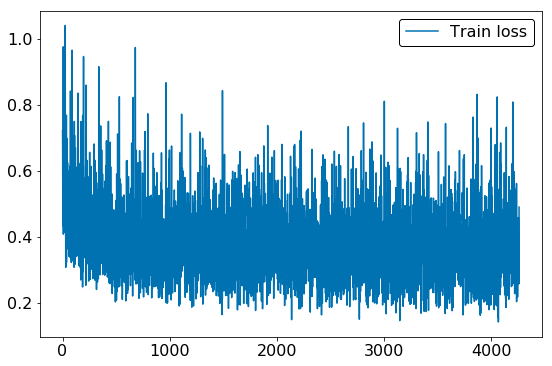

In [10]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

plt.plot(losses,label='Train loss')
#plt.ylim([.4, .8])
plt.legend()
plt.show()

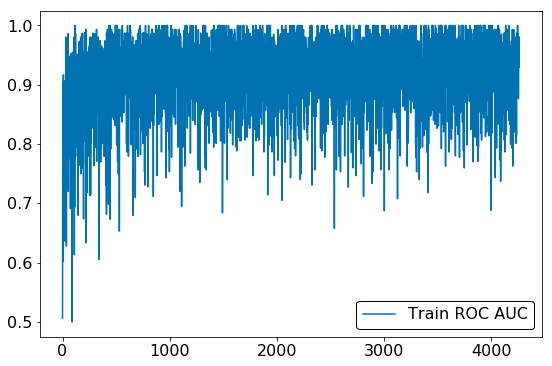

In [11]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

plt.plot(train_roc, label = 'Train ROC AUC')
plt.legend()
plt.show()

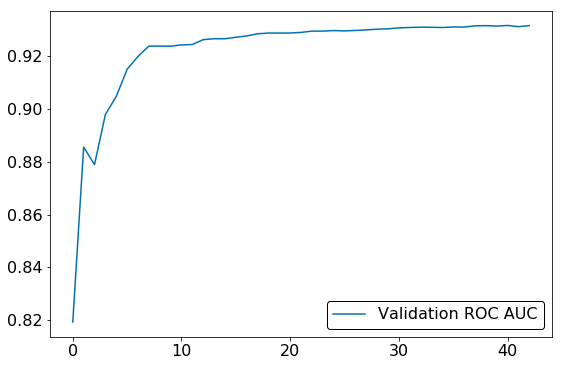

In [12]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

plt.plot(val_roc, label = 'Validation ROC AUC')
plt.legend()
plt.show()


Baseline classification accuracy: 91.39

Model classification accuracy:    84.31


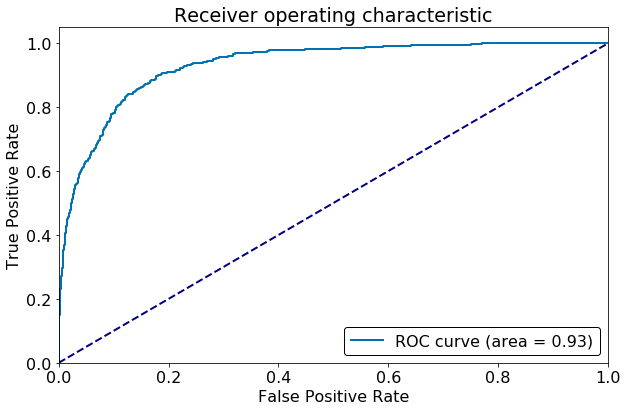

In [13]:
valid_predictions = []
valid_targets = []

model.eval() # prep model for evaluation
with torch.no_grad():
    for i, (images, labels) in enumerate(valid_loader):
        images = images.to(device)

        labels = torch.reshape(labels, [len(labels), 1])
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        valid_predictions += list(outputs.detach().cpu().numpy().ravel())
        valid_targets += list(labels.cpu().numpy().ravel()) 

fpr, tpr, _ = roc_curve(np.array(valid_targets, np.int), np.array(valid_predictions).ravel())
roc_auc = auc(fpr, tpr)

percent_tp = sum(valid_targets)/len(valid_targets) * 100 
baseline = np.max([percent_tp, 100-percent_tp])
acc = 100 * np.sum(np.round(valid_predictions) == np.array(valid_targets)) / len(valid_targets)

print('\nBaseline classification accuracy: {:.2f}'.format(baseline))
print('\nModel classification accuracy:    {:.2f}'.format(acc))

plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

lw = 2
plt.plot(fpr, tpr, 
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [14]:
tn, fp, fn, tp = confusion_matrix(np.array(valid_targets, np.int), np.round(np.array(valid_predictions).ravel())).ravel()

accuracy = (tp + tn) / len(valid_targets)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print("Model accuracy: {:.2f}".format(accuracy))
print("Model precision: {:.2f}".format(precision))
print("Model recall: {:.2f}".format(recall))

print("\nConfusion Matrix: ")
print(confusion_matrix(np.array(valid_targets, np.int), np.round(np.array(valid_predictions).ravel())))

Model accuracy: 0.84
Model precision: 0.34
Model recall: 0.87

Confusion Matrix: 
[[4645  883]
 [  66  455]]


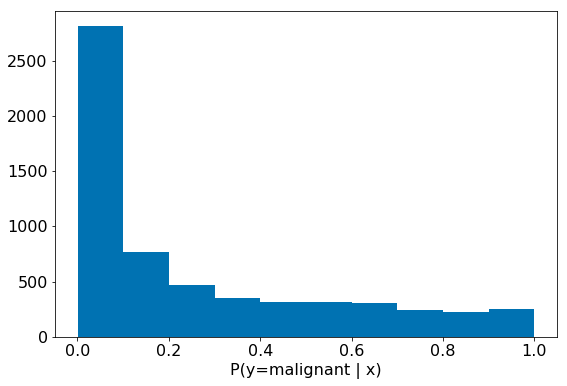

In [15]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

plt.hist(valid_predictions)
plt.xlabel("P(y=malignant | x)")
plt.show()

In [ ]:
#train_df.to_csv("ENET_train_df_all.csv", index=False)
#val_df.to_csv("ENET_val_df_all.csv", index=False)